# 0. Installing MITgcm in the ECCO configuration
The ECCO configuration of the MITgcm is the basis for all of our results. While it is not necessary to install and run the model to obtain the forcing data matrices (which can be calculated straight from the model input files), it is needed to obtain adjoint sensitivity matrices, and, ultimately, the DPC--EDF decomposition, as well as being used to test the model response to EDF patterns.

Full instructions on installing the model can be found in `ECCO_adjoint_instructions.pdf`.

# 1. Obtaining ECCO forcing files and calculating associated data matrices and EOF/PC decomposition

As the DPC--EDF method requires information from both a forcing data matrix and an adjoint sensitivity matrix, we begin by obtaining the forcing data matrix directly from the ECCOv4r4 forcing files. These files are in the binary "MDS" format used by MITgcm, with one file per year, at 6 hourly frequency (1460 entries for non-leap years, 1464 entries for leap years).

We will eventually use these files to re-run the (flux-forced) ECCO state estimate, so it is worth downloading all ECCOv4r4 forcing files. The process is described in Section 2.5.1 of `ECCO_adjoint_instructions.pdf`, but is recapped here. The download requires a podaac account and 210GB of storage space. The following command on Linux-based systems will obtain the necessary files. Change `<YOUR_USERNAME>` for your podaac username.

```
wget -r --no-parent --user <YOUR_USERNAME> --ask-password \
https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/other
mv ecco.jpl.nasa.gov/drive/files/Version4/Release4/other/ .
rm -r ecco.jpl.nasa.gov/
```

We also want the file `ECCO-GRID.nc` which contains information about the LLC90 grid on which the state estimate is run.

```
wget -r --no-parent --user <YOUR_USERNAME> --ask-password \
https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/nctiles_grid/ECCO-GRID.nc
mv ecco.jpl.nasa.gov/drive/files/Version4/Release4/nctiles_grid/ECCO-GRID.nc .
rm -r ecco.jpl.nasa.gov/
```

We will use the function `get_ecco_forcing` from the attached `DPC_functions.py` to load the `hflux` (net heat flux, Wm⁻², positive out of the ocean),`oceTAUX`, and `oceTAUY` (x-oriented and y-oriented -not zonal and meridional- wind stress, Nm⁻²) variables used in part to force the flux-forced simulation. This function returns the raw forcing and a climatology calculated from it. The function `forcing_anom` takes these two outputs and diagnoses the anomaly data matrix used to calculate EOFs and PCs.

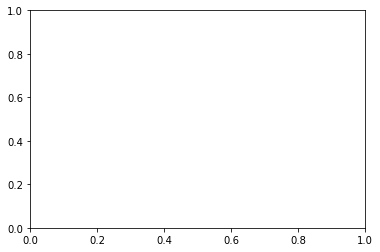

In [2]:
from DPC_functions import *

In [13]:
get_ecco_forcing?

Signature:
get_ecco_forcing(
    variable_name,
    forcing_dir=None,
    nsteps_mean=1,
    calc_clim=True,
    show_progress=False,
)
Docstring:
Load raw ECCOv4r4 6-hourly surface forcing files as a numpy array, optionally calculating
their climatology.

Parameters:
-----------
variable_name (str): name of the surface forcing variable, from the following:
    name - documented name; description
    STANDARD ECCO
    ------------------------------------------------------
    dlw - lwdown; Downward longwave radiation in W/m^2
    dsw - swdown; Downward shortwave radiation in W/m^2
    pres - apressure; Atmospheric pressure field in N/m^2
    rain - precip; Precipitation in m/s
    spfh2m - aqh; Surface (2m) specific humidity in kg/kg
    tmp2m - atemp; Surface (2-m) air temperature in deg K
    ustr - ustress; Zonal surface wind stress in N/m^2
    vstr - vstress; Meridional surface wind stress in N/m^2
    wspeed - wspeed; Surface (10-m) wind speed in m/s
    -------------------------

## Get the heat flux data matrix

In [25]:
# forcingdir='/where/you/downloaded/ECCO/files/other/flux-forced/forcing/'
forcingdir='/glade/work/dafydd/ECCOv4r4_input/other/flux-forced/forcing'
hflux_X,hflux_X_clim=get_ecco_forcing('TFLUX',forcing_dir=forcingdir,show_progress=True)
hflux_X=forcing_anom(hflux_X,hflux_X_clim)

## Reduce the spatial dimensions of the data matrix to the Atlantic in [-35,80]°N 
We use the indexing variable `Ti` which is calculated in `DPC_functions`. This reduces the heat flux anomaly data matrix to shape (37988,10469) [time x space]

In [26]:
hflux_X=hflux_X.reshape(-1,13*90*90)[:,Ti]
print(hflux_X.shape)

In [ ]:
np.save('hflux_anomaly_data_matrix.npy')

## Calculate EOFs as the eigendecomposition of the covariance matrix XᵀX

In [28]:
%%time
hflux_C = ( 1/len(hflux_X) ) * (hflux_X.T).dot(hflux_X)
hflux_λ,hflux_EOFs=la.eigsh(hflux_C,k=10469)

/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1593: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


CPU times: user 4min, sys: 550 ms, total: 4min
Wall time: 4min 7s


In [47]:
%%time
hflux_PCs=hflux_X.dot(hflux_EOFs)/np.sqrt(hflux_λ*len(hflux_X))

CPU times: user 1min 22s, sys: 1.23 s, total: 1min 24s
Wall time: 1min 25s


## As above, for wind stress
We concatenate the two variables `oceTAUX` and `oceTAUY` into a single data matrix:

In [50]:
%%time
# forcingdir='/where/you/downloaded/ECCO/files/other/flux-forced/forcing/'
forcingdir='/glade/work/dafydd/ECCOv4r4_input/other/flux-forced/forcing'
taux_X,taux_X_clim=get_ecco_forcing('oceTAUX',forcing_dir=forcingdir,show_progress=False)
taux_X=forcing_anom(taux_X,taux_X_clim)
taux_X=taux_X.reshape(-1,13*90*90)[:,Ui]

tauy_X,tauy_X_clim=get_ecco_forcing('oceTAUY',forcing_dir=forcingdir,show_progress=False)
tauy_X=forcing_anom(tauy_X,tauy_X_clim)
tauy_X=tauy_X.reshape(-1,13*90*90)[:,Vi]

tauxy_X=np.hstack([taux_X,tauy_X])

CPU times: user 1min 58s, sys: 1min 27s, total: 3min 25s
Wall time: 3min 33s


In [ ]:
np.save('tauxy_anomaly_data_matrix.npy')

In [54]:
%%time
tauxy_C = ( 1/len(tauxy_X) ) * (tauxy_X.T).dot(tauxy_X)
tauxy_λ,tauxy_EOFs=la.eigsh(tauxy_C,k=20280)
tauxy_PCs=tauxy_X.dot(tauxy_EOFs)/np.sqrt(tauxy_λ*len(tauxy_X))

CPU times: user 32min 26s, sys: 5.82 s, total: 32min 32s
Wall time: 33min 5s
